# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

In [2]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [3]:
from functions import momentos, gauss, gauss_fit, pulso, delay_pulse_pair, get_mean_pulse_from_set, get_closest, move_to_reference, pulso_poisson
from Models import model_definition

# **PREPROCESSING**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo, V28, kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo, V55, kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo, V82, kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


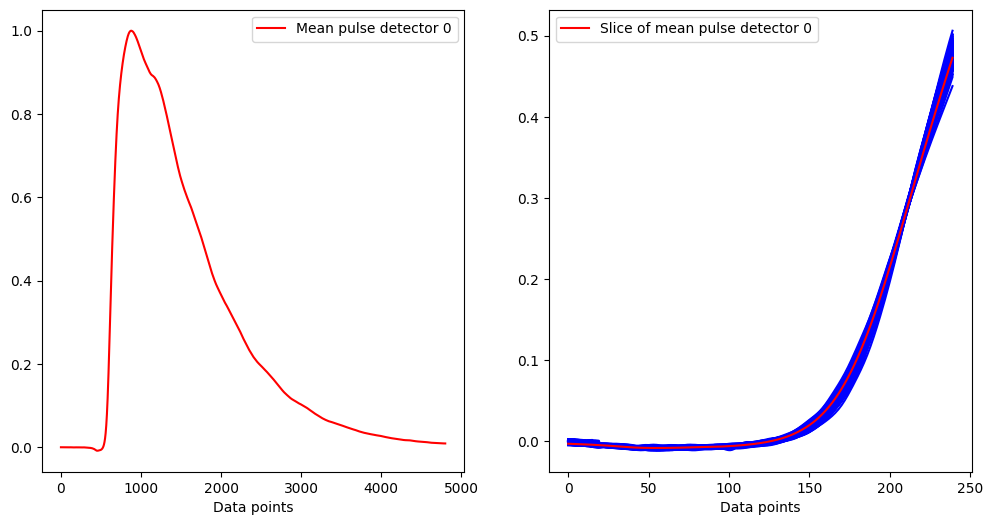

In [5]:
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING
mean_dec0 = get_mean_pulse_from_set(new_V55, channel=0)
delay, moved_pulses = move_to_reference(mean_dec0, new_V55, start = start, stop = stop, max_delay = int(stop-start), channel = 0)

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(mean_dec0, 'r-', label = 'Mean pulse detector 0')
plt.xlabel('Data points')
plt.legend()
plt.subplot(122)
for i in range(moved_pulses.shape[0]):
    plt.plot(moved_pulses[i,:], 'b-')
plt.plot(mean_dec0[start:stop], 'r-', label = 'Slice of mean pulse detector 0')
plt.xlabel('Data points')
plt.legend()

In [76]:
Num_casos = 10000
Ntest = int(0.1*Num_casos)
Nc = 2

t_shift = 8 #In time steps 
t0 = 65 + np.random.randint(5, size = Num_casos) 
tt=np.linspace(0,600,600)   #time step of 0.2ns

# **DETECTOR 0**

In [77]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 25
tau_drop_dec0 = 150
Photon_yield = 15000

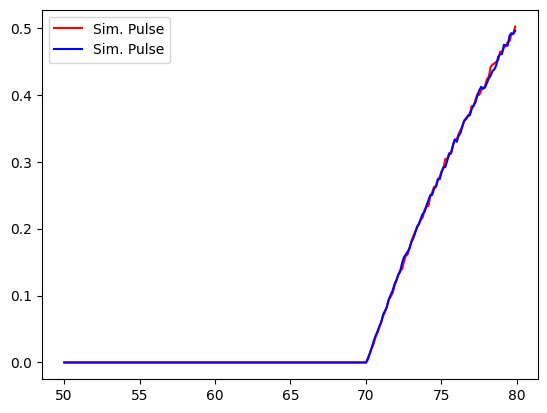

In [78]:
pulso_original = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
pulso_original2 = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
plt.plot(tiempo_new[start:stop], pulso_original[start:stop],'r-', label = 'Sim. Pulse')
plt.plot(tiempo_new[start:stop], pulso_original2[start:stop],'b-', label = 'Sim. Pulse')
plt.legend()

In [79]:
#------------------------------------------- Simulate detector pulses --------------------
INPUT_dec0 = np.zeros((Num_casos,Nt_new,Nc))

for i in range(Num_casos):
  centro = t0[i]
  noise = np.random.normal(scale=1e-4, size=t_shift)
  
  PULSO = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True) 
  INPUT_dec0[i,:,0] = PULSO
  INPUT_dec0[i,:,1] = np.roll(PULSO, t_shift)
  INPUT_dec0[i,0:t_shift,1] = noise

#------------------------------------------- Create train set ---------------------------
trainX_dec0, REF_train_dec0 = delay_pulse_pair(INPUT_dec0[:,start:stop,:], new_time_step, t_shift = t_shift, delay_steps = 32)

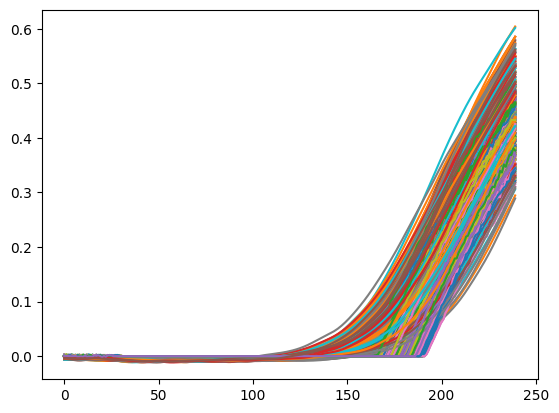

In [80]:
for i in range(new_V55.shape[0]):
  plt.plot(trainX_dec0[i,:,0])
  plt.plot(new_V55[i,start:stop,0])

In [81]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)

NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print('Min dec0 =', min_dec0)
print('Max dec0 =', max_dec0)

(10000, 12, 2) NM = 12
Min dec0 = 0.32155161511150826
Max dec0 = 22.761177119216548


# **DETECTOR 1**

In [82]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec1 = 20
tau_drop_dec1 = 150
Photon_yield = 15000

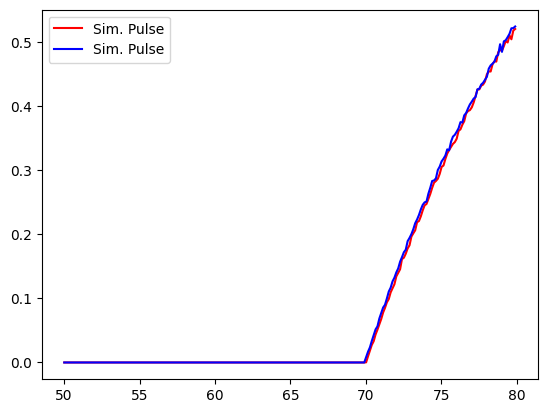

In [83]:
pulso_original = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)
pulso_original2 = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)
plt.plot(tiempo_new[start:stop], pulso_original[start:stop],'r-', label = 'Sim. Pulse')
plt.plot(tiempo_new[start:stop], pulso_original2[start:stop],'b-', label = 'Sim. Pulse')
plt.legend()

In [84]:
#------------------------------------------- Simulate detector pulses ---------------------------
INPUT_dec1 = np.zeros((Num_casos,Nt_new,Nc))

for i in range(Num_casos):
  centro = t0[i]
  noise = np.random.normal(scale = 1e-4, size = t_shift)
  
  PULSO = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)

  INPUT_dec1[i,:,0] = PULSO
  INPUT_dec1[i,:,1] = np.roll(PULSO, t_shift)
  INPUT_dec1[i,0:t_shift,1] = noise

#------------------------------------------- Create train set ---------------------------
trainX_dec1, REF_train_dec1 = delay_pulse_pair(INPUT_dec1[:,start:stop,:], new_time_step, t_shift = t_shift, delay_steps = 32)

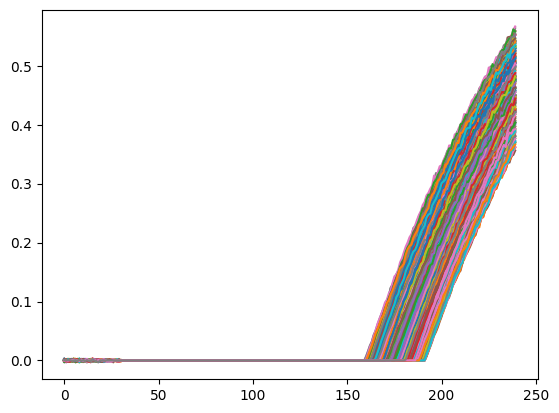

In [95]:
for i in range(new_V55.shape[0]):
  plt.plot(trainX_dec1[i,:,0])

In [96]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print('Min dec1 =', min_dec1)
print('Max dec1 =', max_dec1)

(10000, 12, 2) NM = 12
Min dec1 = 0.37246698764547287
Max dec1 = 26.06434709945208


# **CREATE TEST SET** 

In [87]:
#------------------------------------------- Create test set ---------------------------
Test_55 = np.zeros((Ntest,Nt_new,Nc))
Test_28 = np.zeros((Ntest,Nt_new,Nc))
Test_82 = np.zeros((Ntest,Nt_new,Nc))
t_shift_test = 8


for i in range(Ntest):
  centro = t0[i]
  PULSO_dec0 = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  PULSO_dec1 = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)

  Test_55[i,:,0] = PULSO_dec0
  Test_55[i,:,1] = PULSO_dec1

for i in range(Ntest):
  centro = t0[i]
  noise = np.random.normal(scale=1e-4, size = t_shift_test)
  PULSO_dec0 = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  PULSO_dec1 = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)
  
  Test_28[i,:,0] = PULSO_dec0
  Test_28[i,:,1] = np.roll(PULSO_dec1, t_shift_test)
  Test_28[i,0:t_shift_test,1] = noise

for i in range(Ntest):
  centro = t0[i]
  noise = np.random.normal(scale=1e-4, size = t_shift_test)
  PULSO_dec0 = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  PULSO_dec1 = pulso_poisson(tiempo_new, 70, A = Photon_yield, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)
  
  Test_82[i,:,0] = np.roll(PULSO_dec0, t_shift_test)
  Test_82[i,0:t_shift_test,0] = noise
  Test_82[i,:,1] = PULSO_dec1

# **FULL TOF**

In [88]:
#---------------------------------------- Create Reference pulse -----------------------
REFERENCE_PULSE_dec0 = np.tile(new_V82[0,:,0], (Ntest,2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_V82[0,:,1], (Ntest,2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)

M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)

In [89]:
#---------------------------------------- Create test set ------------------------------
M_V28 = momentos(Test_28[:,start:stop,:])
M_V28_norm = np.zeros_like(M_V28)
M_V28_norm[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28_norm[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(Test_55[:,start:stop,:])
M_V55_norm = np.zeros_like(M_V55)
M_V55_norm[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55_norm[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(Test_82[:,start:stop,:])
M_V82_norm = np.zeros_like(M_V82)
M_V82_norm[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82_norm[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)


(1000, 12, 2)
(1000, 12, 2)
(1000, 12, 2)


In [90]:
epochs = 75
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(num_semillas):

  model_dec0 = model_definition(NM = NM, NN = 32, STD_INIT = 1)
  model_dec1 = model_definition(NM = NM, NN = 32, STD_INIT = 1)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 1e-3)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 1e-3)

  model_dec0.compile(optimizer = opt_dec0, loss = 'MSE')
  model_dec1.compile(optimizer = opt_dec1, loss = 'MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):
     
     history_dec0 = model_dec0.fit(x = [M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]], y = REF_train_dec0, epochs = 5, batch_size = 256, shuffle = True, verbose=1)
     history_dec1 = model_dec1.fit(x = [M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]], y = REF_train_dec1, epochs = 5, batch_size = 256, shuffle = True, verbose=1)
     
     loss_dec0.append(history_dec0.history['loss'][-1])
     loss_dec1.append(history_dec1.history['loss'][-1])

     
     TOFN_dec0_REF_V82 = model_dec0.predict([M_V82_norm[:,:,0], M_REF_dec0[:M_V82_norm.shape[0],:,0]])
     TOFN_dec1_REF_V82 = model_dec1.predict([M_V82_norm[:,:,1], M_REF_dec1[:M_V82_norm.shape[0],:,0]])
     TOFN_dec0_REF_V55 = model_dec0.predict([M_V55_norm[:,:,0], M_REF_dec0[:M_V55_norm.shape[0],:,0]])
     TOFN_dec1_REF_V55 = model_dec1.predict([M_V55_norm[:,:,1], M_REF_dec1[:M_V55_norm.shape[0],:,0]])
     TOFN_dec0_REF_V28 = model_dec0.predict([M_V28_norm[:,:,0], M_REF_dec0[:M_V28_norm.shape[0],:,0]])
     TOFN_dec1_REF_V28 = model_dec1.predict([M_V28_norm[:,:,1], M_REF_dec1[:M_V28_norm.shape[0],:,0]])


     TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
    
     TOFN_V28_epoch.append(TOFN_V28)
     TOFN_V55_epoch.append(TOFN_V55)
     TOFN_V82_epoch.append(TOFN_V82)


     centroid_V28 = np.mean(TOFN_V28) - np.mean(TOFN_V55)
     centroid_V82 = np.mean(TOFN_V82) - np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype = 'object')
std = np.array(std, dtype = 'object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 23.9671 
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 22.4992
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 21.3924
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 20.3360
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 19.3292
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 62.4330  
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 22.6703
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.5653
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 20.6586
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 19.8058
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 18.3708
Epoch 2/5
40/40 ━━━━━━━━

(array([0]), array([16])) 0.03163196126423449


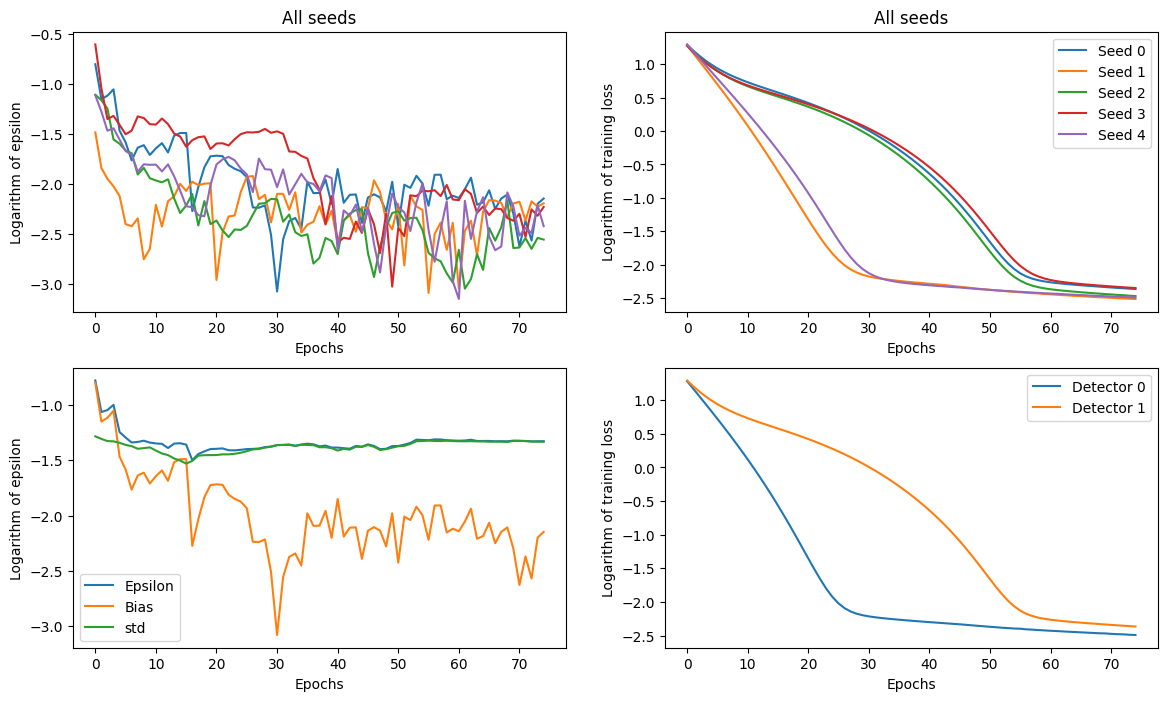

In [97]:
epsilon = np.array(epsilon, dtype = 'float64')
bias = np.array(bias, dtype = 'float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 0

plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  #plt.plot(np.log10(epsilon[i,:]))
  plt.plot(np.log10(bias[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label = label)
  plt.plot(np.log10(training_loss_dec1[i,:]), label = label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]), label = 'Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]), label = 'Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.199  FWHM(ns) = 0.086  std(ns) = 0.037
V55: CENTROID(ns) = -0.000  FWHM(ns) = 0.079  std(ns) = 0.033
V28: CENTROID(ns) = -0.216  FWHM(ns) = 0.072  std(ns) = 0.031


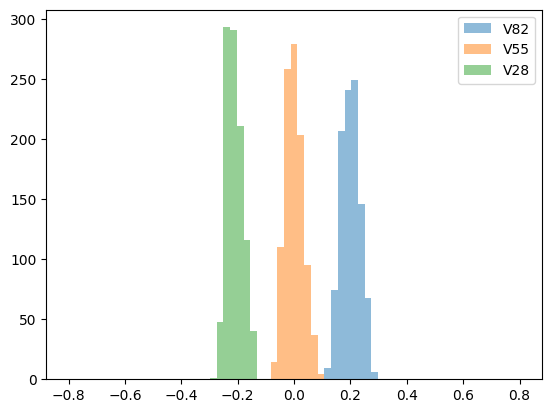

In [101]:
epoch = 16
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 67
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

# **ENSEMBLE MODEL**

In [99]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_V28 = np.average(np.squeeze(TOFN_V28_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V55 = np.average(np.squeeze(TOFN_V55_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V82 = np.average(np.squeeze(TOFN_V82_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)


V82: CENTROID(ns) = 0.195  FWHM(ns) = 0.116  std(ns) = 0.049
V55: CENTROID(ns) = -0.002  FWHM(ns) = 0.124  std(ns) = 0.053
V28: CENTROID(ns) = -0.206  FWHM(ns) = 0.111  std(ns) = 0.047


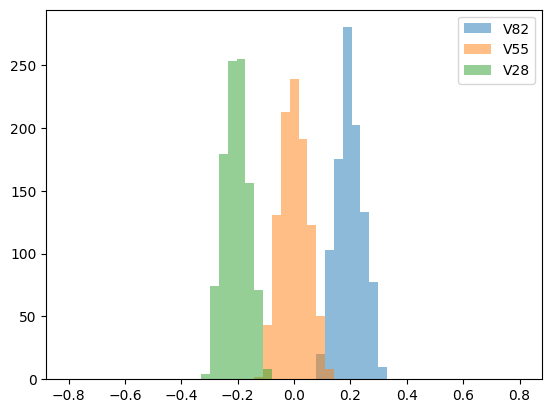

In [100]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(weighted_mean_V82 - np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(weighted_mean_V55 - np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(weighted_mean_V28 - np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))